# Workflow for a multi-regional energy system

In this application of the FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import FINE as fn
import matplotlib.pyplot as plt
from getData import getData
import pandas as pd
import os

cwd = os.getcwd()
data = getData()

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = {
    "cluster_0",
    "cluster_1",
    "cluster_2",
    "cluster_3",
    "cluster_4",
    "cluster_5",
    "cluster_6",
    "cluster_7",
}
commodityUnitDict = {
    "electricity": r"GW$_{el}$",
    "methane": r"GW$_{CH_{4},LHV}$",
    "biogas": r"GW$_{biogas,LHV}$",
    "CO2": r"Mio. t$_{CO_2}$/h",
    "hydrogen": r"GW$_{H_{2},LHV}$",
}
commodities = {"electricity", "hydrogen", "methane", "biogas", "CO2"}
numberOfTimeSteps = 8760
hoursPerTimeStep = 1

In [3]:
esM = fn.EnergySystemModel(
    locations=locations,
    commodities=commodities,
    numberOfTimeSteps=8760,
    commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=1,
    costUnit="1e9 Euro",
    lengthUnit="km",
    verboseLogLevel=0,
)

In [4]:
CO2_reductionTarget = 1

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [5]:
esM.add(
    fn.Source(
        esM=esM,
        name="Wind (onshore)",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax=data["Wind (onshore), operationRateMax"],
        capacityMax=data["Wind (onshore), capacityMax"],
        investPerCapacity=1.1,
        opexPerCapacity=1.1 * 0.02,
        interestRate=0.08,
        economicLifetime=20,
    )
)

Full load hours:

In [6]:
data["Wind (onshore), operationRateMax"].sum()

cluster_0    1572.003960
cluster_1    2350.292663
cluster_2    2374.507270
cluster_3    2186.572278
cluster_4    1572.650655
cluster_5    1767.840650
cluster_6    2719.564564
cluster_7    1553.045964
dtype: float64

### Wind offshore

In [7]:
esM.add(
    fn.Source(
        esM=esM,
        name="Wind (offshore)",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax=data["Wind (offshore), operationRateMax"],
        capacityMax=data["Wind (offshore), capacityMax"],
        investPerCapacity=2.3,
        opexPerCapacity=2.3 * 0.02,
        interestRate=0.08,
        economicLifetime=20,
    )
)

Full load hours:

In [8]:
data["Wind (offshore), operationRateMax"].sum()

cluster_0       0.000000
cluster_1    4435.420314
cluster_2    4301.655834
cluster_3    3902.391858
cluster_4       0.000000
cluster_5       0.000000
cluster_6    4609.508396
cluster_7       0.000000
dtype: float64

### PV

In [9]:
esM.add(
    fn.Source(
        esM=esM,
        name="PV",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax=data["PV, operationRateMax"],
        capacityMax=data["PV, capacityMax"],
        investPerCapacity=0.65,
        opexPerCapacity=0.65 * 0.02,
        interestRate=0.08,
        economicLifetime=25,
    )
)

Full load hours:

In [10]:
data["PV, operationRateMax"].sum()

cluster_0    1113.216464
cluster_1    1053.579422
cluster_2    1058.005181
cluster_3    1079.872237
cluster_4    1140.407380
cluster_5    1051.848141
cluster_6    1069.843344
cluster_7    1085.697466
dtype: float64

### Exisisting run-of-river hydroelectricity plants

In [11]:
esM.add(
    fn.Source(
        esM=esM,
        name="Existing run-of-river plants",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateFix=data["Existing run-of-river plants, operationRateFix"],
        tsaWeight=0.01,
        capacityFix=data["Existing run-of-river plants, capacityFix"],
        investPerCapacity=0,
        opexPerCapacity=0.208,
    )
)

## 3.2. Methane (natural gas and biogas)

### Natural gas

In [12]:
esM.add(
    fn.Source(
        esM=esM,
        name="Natural gas purchase",
        commodity="methane",
        hasCapacityVariable=False,
        commodityCost=0.0331 * 1e-3,
    )
)

### Biogas

In [13]:
esM.add(
    fn.Source(
        esM=esM,
        name="Biogas purchase",
        commodity="biogas",
        operationRateMax=data["Biogas, operationRateMax"],
        hasCapacityVariable=False,
        commodityCost=0.05409 * 1e-3,
    )
)

# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

In [14]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="CCGT plants (methane)",
        physicalUnit=r"GW$_{el}$",
        commodityConversionFactors={
            "electricity": 1,
            "methane": -1 / 0.6,
            "CO2": 201 * 1e-6 / 0.6,
        },
        hasCapacityVariable=True,
        investPerCapacity=0.65,
        opexPerCapacity=0.021,
        interestRate=0.08,
        economicLifetime=33,
    )
)

### New combined cycle gas turbine plants for biogas

In [15]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="New CCGT plants (biogas)",
        physicalUnit=r"GW$_{el}$",
        commodityConversionFactors={"electricity": 1, "biogas": -1 / 0.63},
        hasCapacityVariable=True,
        investPerCapacity=0.7,
        opexPerCapacity=0.021,
        interestRate=0.08,
        economicLifetime=33,
    )
)

### New combined cycly gas turbines for hydrogen

In [16]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="New CCGT plants (hydrogen)",
        physicalUnit=r"GW$_{el}$",
        commodityConversionFactors={"electricity": 1, "hydrogen": -1 / 0.63},
        hasCapacityVariable=True,
        investPerCapacity=0.7,
        opexPerCapacity=0.021,
        interestRate=0.08,
        economicLifetime=33,
    )
)

### Electrolyzers

In [17]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="Electrolyzer",
        physicalUnit=r"GW$_{el}$",
        commodityConversionFactors={"electricity": -1, "hydrogen": 0.7},
        hasCapacityVariable=True,
        investPerCapacity=0.5,
        opexPerCapacity=0.5 * 0.025,
        interestRate=0.08,
        economicLifetime=10,
    )
)

### rSOC

In [18]:
capexRSOC = 1.5

esM.add(
    fn.Conversion(
        esM=esM,
        name="rSOEC",
        physicalUnit=r"GW$_{el}$",
        linkedConversionCapacityID="rSOC",
        commodityConversionFactors={"electricity": -1, "hydrogen": 0.6},
        hasCapacityVariable=True,
        investPerCapacity=capexRSOC / 2,
        opexPerCapacity=capexRSOC * 0.02 / 2,
        interestRate=0.08,
        economicLifetime=10,
    )
)

esM.add(
    fn.Conversion(
        esM=esM,
        name="rSOFC",
        physicalUnit=r"GW$_{el}$",
        linkedConversionCapacityID="rSOC",
        commodityConversionFactors={"electricity": 1, "hydrogen": -1 / 0.6},
        hasCapacityVariable=True,
        investPerCapacity=capexRSOC / 2,
        opexPerCapacity=capexRSOC * 0.02 / 2,
        interestRate=0.08,
        economicLifetime=10,
    )
)

# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [19]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Li-ion batteries",
        commodity="electricity",
        hasCapacityVariable=True,
        chargeEfficiency=0.95,
        cyclicLifetime=10000,
        dischargeEfficiency=0.95,
        selfDischarge=1 - (1 - 0.03) ** (1 / (30 * 24)),
        chargeRate=1,
        dischargeRate=1,
        doPreciseTsaModeling=False,
        investPerCapacity=0.151,
        opexPerCapacity=0.002,
        interestRate=0.08,
        economicLifetime=22,
    )
)

## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [20]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Salt caverns (hydrogen)",
        commodity="hydrogen",
        hasCapacityVariable=True,
        capacityVariableDomain="continuous",
        capacityPerPlantUnit=133,
        chargeRate=1 / 470.37,
        dischargeRate=1 / 470.37,
        sharedPotentialID="Existing salt caverns",
        stateOfChargeMin=0.33,
        stateOfChargeMax=1,
        capacityMax=data["Salt caverns (hydrogen), capacityMax"],
        investPerCapacity=0.00011,
        opexPerCapacity=0.00057,
        interestRate=0.08,
        economicLifetime=30,
    )
)

## 5.3. Methane storage

### Methane filled salt caverns

In [21]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Salt caverns (biogas)",
        commodity="biogas",
        hasCapacityVariable=True,
        capacityVariableDomain="continuous",
        capacityPerPlantUnit=443,
        chargeRate=1 / 470.37,
        dischargeRate=1 / 470.37,
        sharedPotentialID="Existing salt caverns",
        stateOfChargeMin=0.33,
        stateOfChargeMax=1,
        capacityMax=data["Salt caverns (methane), capacityMax"],
        investPerCapacity=0.00004,
        opexPerCapacity=0.00001,
        interestRate=0.08,
        economicLifetime=30,
    )
)

## 5.4 Pumped hydro storage

### Pumped hydro storage

In [22]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Pumped hydro storage",
        commodity="electricity",
        chargeEfficiency=0.88,
        dischargeEfficiency=0.88,
        hasCapacityVariable=True,
        selfDischarge=1 - (1 - 0.00375) ** (1 / (30 * 24)),
        chargeRate=0.16,
        dischargeRate=0.12,
        capacityFix=data["Pumped hydro storage, capacityFix"],
        investPerCapacity=0,
        opexPerCapacity=0.000153,
    )
)

# 6. Add commodity transmission components to the energy system model

## 6.1. Electricity transmission

### AC cables

esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

In [23]:
esM.add(
    fn.Transmission(
        esM=esM,
        name="AC cables",
        commodity="electricity",
        hasCapacityVariable=True,
        capacityFix=data["AC cables, capacityFix"],
    )
)

The distances of a component are set to a normalized value of 1.


### DC cables

In [24]:
esM.add(
    fn.Transmission(
        esM=esM,
        name="DC cables",
        commodity="electricity",
        losses=data["DC cables, losses"],
        distances=data["DC cables, distances"],
        hasCapacityVariable=True,
        capacityFix=data["DC cables, capacityFix"],
    )
)

## 6.2 Methane transmission

### Methane pipeline

In [25]:
esM.add(
    fn.Transmission(
        esM=esM,
        name="Pipelines (biogas)",
        commodity="biogas",
        distances=data["Pipelines, distances"],
        hasCapacityVariable=True,
        hasIsBuiltBinaryVariable=True,
        bigM=300,
        locationalEligibility=data["Pipelines, eligibility"],
        capacityMax=data["Pipelines, eligibility"] * 15,
        sharedPotentialID="pipelines",
        investPerCapacity=0.000037,
        investIfBuilt=0.000314,
        interestRate=0.08,
        economicLifetime=40,
    )
)

## 6.3 Hydrogen transmission

### Hydrogen pipelines

In [26]:
esM.add(
    fn.Transmission(
        esM=esM,
        name="Pipelines (hydrogen)",
        commodity="hydrogen",
        distances=data["Pipelines, distances"],
        hasCapacityVariable=True,
        hasIsBuiltBinaryVariable=True,
        bigM=300,
        locationalEligibility=data["Pipelines, eligibility"],
        capacityMax=data["Pipelines, eligibility"] * 15,
        sharedPotentialID="pipelines",
        investPerCapacity=0.000177,
        investIfBuilt=0.00033,
        interestRate=0.08,
        economicLifetime=40,
    )
)

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [27]:
esM.add(
    fn.Sink(
        esM=esM,
        name="Electricity demand",
        commodity="electricity",
        hasCapacityVariable=False,
        operationRateFix=data["Electricity demand, operationRateFix"],
    )
)

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [28]:
FCEV_penetration = 0.5
esM.add(
    fn.Sink(
        esM=esM,
        name="Hydrogen demand",
        commodity="hydrogen",
        hasCapacityVariable=False,
        operationRateFix=data["Hydrogen demand, operationRateFix"] * FCEV_penetration,
    )
)

## 7.3. CO2 sinks

### CO2 exiting the system's boundary

In [29]:
esM.add(
    fn.Sink(
        esM=esM,
        name="CO2 to enviroment",
        commodity="CO2",
        hasCapacityVariable=False,
        commodityLimitID="CO2 limit",
        yearlyLimit=366 * (1 - CO2_reductionTarget),
    )
)

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

# 8 Temporal Aggregation

In [30]:
esM.aggregateTemporally(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period...
		(2.3767 sec)



 C:\Users\t.gross\Anaconda3\envs\dev_FINE\lib\site-packages\tsam\timeseriesaggregation.py:1070: UserWarning:Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series


### Optimization

In [31]:
# The `optimizationSpecs` only work with the Gurobi solver. If you are using another solver you need to choose
# specs spcecific to this solver or no specs.
esM.optimize(
    timeSeriesAggregation=True,
    optimizationSpecs="OptimalityTol=1e-3 method=2 cuts=0 MIPGap=5e-3",
)

Time series aggregation specifications:
Number of typical periods:7, number of time steps per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.7352 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3377 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(2.5192 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.6316 sec)

Declaring shared potential constraint...
		(0.0030 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(1.0349 sec)

		(0.0000 sec)

Declaring objective function...
		(0.4120 sec)

Either solver not selected or specified solver not available.

for SourceSinkModel ...    (1.6979sec)
for ConversionModel ...    (1.3208sec)


 c:\users\t.gross\documents\programming\jugit\fine\FINE\storage.py:1767: UserWarning:Charge and discharge at the same time for component Li-ion batteries
 c:\users\t.gross\documents\programming\jugit\fine\FINE\storage.py:1767: UserWarning:Charge and discharge at the same time for component Pumped hydro storage
 c:\users\t.gross\documents\programming\jugit\fine\FINE\storage.py:1767: UserWarning:Charge and discharge at the same time for component Salt caverns (biogas)
 c:\users\t.gross\documents\programming\jugit\fine\FINE\storage.py:1767: UserWarning:Charge and discharge at the same time for component Salt caverns (hydrogen)


for StorageModel ...       (3.7737sec)
for TransmissionModel ...  (4.1164sec)
		(10.9316 sec)



# 9. Selected results output

Plot locations (GeoPandas required)

In [32]:
# Import the geopandas package for plotting the locations
import geopandas as gpd

In [33]:
locFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "clusteredRegions.shp"
)

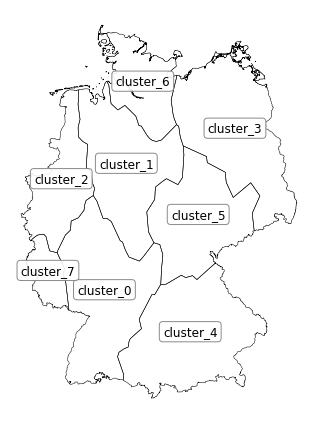

In [34]:
fig, ax = fn.plotLocations(locFilePath, plotLocNames=True, indexColumn="index")

### Sources and Sink

Show optimization summary

In [35]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

cluster_0  \
Component                    Property    Unit                                
Biogas purchase              TAC         [1e9 Euro/a]             0.264223   
                             commodCosts [1e9 Euro/a]             0.264223   
                             operation   [GW$_{biogas,LHV}$*h/a]   4884.88   
                                         [GW$_{biogas,LHV}$*h]     4884.88   
Electricity demand           operation   [GW$_{el}$*h/a]            133963   
                                         [GW$_{el}$*h]              133963   
Existing run-of-river plants TAC         [1e9 Euro/a]             0.144316   
                             capacity    [GW$_{el}$]              0.693828   
                             operation   [GW$_{el}$*h/a]           3167.33   
                                         [GW$_{el}$*h]             3167.33   
                             opexCap     [1e9 Euro/a]             0.144316   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]    15855.2   
                                         [GW$_{H_{2},LHV}$*h]      15855.2   
PV                           TAC         [1e9 Euro/a]              3.09268   
                             capacity    [GW$_{el}$]               41.8544   
                             capexCap    [1e9 Euro/a]              2.54857   
                             invest      [1e9 Euro]                27.2054   
                             operation   [GW$_{el}$*h/a]             38288   
                                         [GW$_{el}$*h]               38288   
                             opexCap     [1e9 Euro/a]             0.544108   
Wind (offshore)              TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                   NaN   
                             capexCap    [1e9 Euro/a]                  NaN   
                             invest      [1e9 Euro]                    NaN   
                             operation   [GW$_{el}$*h/a]               NaN   
                                         [GW$_{el}$*h]                 NaN   
                             opexCap     [1e9 Euro/a]                  NaN   
Wind (onshore)               TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                     0   
                             capexCap    [1e9 Euro/a]                    0   
                             invest      [1e9 Euro]                      0   
                             operation   [GW$_{el}$*h/a]                 0   
                                         [GW$_{el}$*h]                   0   
                             opexCap     [1e9 Euro/a]                    0   

                                                                  cluster_1  \
Component                    Property    Unit                                 
Biogas purchase              TAC         [1e9 Euro/a]              0.253751   
                             commodCosts [1e9 Euro/a]              0.253751   
                             operation   [GW$_{biogas,LHV}$*h/a]    4691.28   
                                         [GW$_{biogas,LHV}$*h]      4691.28   
Electricity demand           operation   [GW$_{el}$*h/a]              66116   
                                         [GW$_{el}$*h]                66116   
Existing run-of-river plants TAC         [1e9 Euro/a]             0.0077909   
                             capacity    [GW$_{el}$]              0.0374563   
                             operation   [GW$_{el}$*h/a]            170.988   
                                         [GW$_{el}$*h]              170.988   
                             opexCap     [1e9 Euro/a]             0.0077909   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]     11007.1   
                                         [GW$_{H_{2},LHV}$*h]       11007.1   
PV                           TAC         [1e9 Euro/a]               1.9

Plot installed capacities

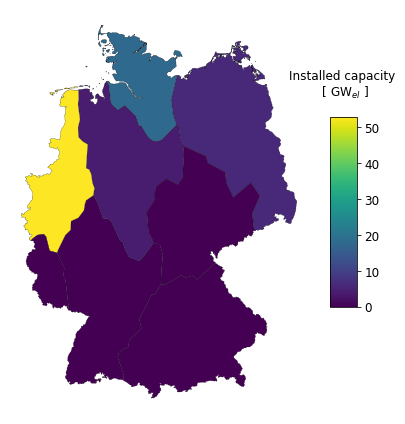

In [36]:
fig, ax = fn.plotLocationalColorMap(
    esM, "Wind (offshore)", locFilePath, "index", perArea=False
)

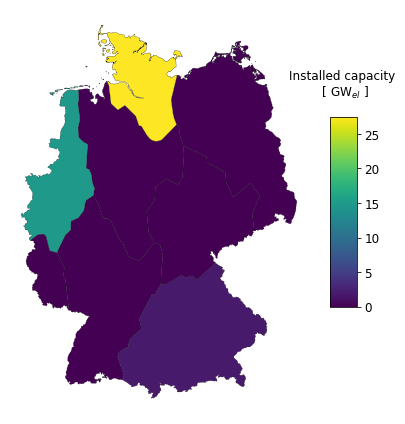

In [37]:
fig, ax = fn.plotLocationalColorMap(
    esM, "Wind (onshore)", locFilePath, "index", perArea=False
)

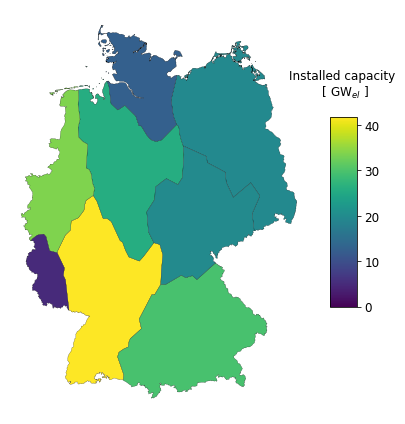

In [38]:
fig, ax = fn.plotLocationalColorMap(esM, "PV", locFilePath, "index", perArea=False)

Plot operation time series (either one or two dimensional)

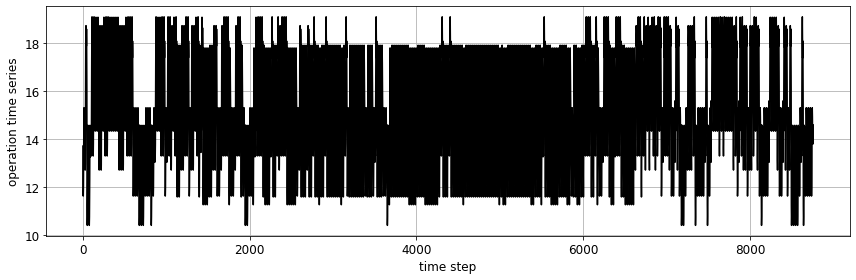

In [39]:
fig, ax = fn.plotOperation(esM, "Electricity demand", "cluster_0")

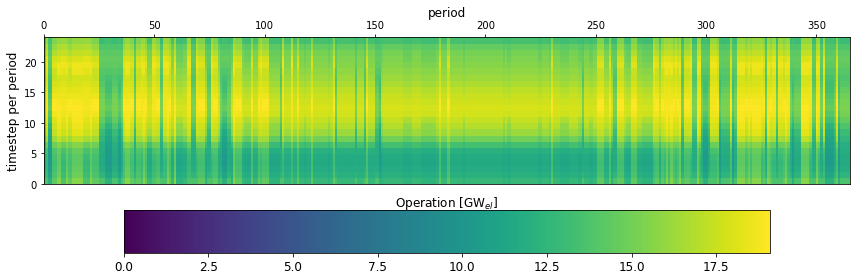

In [40]:
fig, ax = fn.plotOperationColorMap(esM, "Electricity demand", "cluster_0")

### Conversion

Show optimization summary

In [41]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

cluster_0   cluster_1  \
Component                Property  Unit                                      
Electrolyzer             TAC       [1e9 Euro/a]      0.0185394   0.0590047   
                         capacity  [GW$_{el}$]        0.213061      0.6781   
                         capexCap  [1e9 Euro/a]      0.0158762   0.0505285   
                         invest    [1e9 Euro]          0.10653     0.33905   
                         operation [GW$_{el}$*h/a]     721.211     2063.46   
                                   [GW$_{el}$*h]       721.211     2063.46   
                         opexCap   [1e9 Euro/a]     0.00266326  0.00847626   
New CCGT plants (biogas) TAC       [1e9 Euro/a]      0.0574716    0.231794   
                         capacity  [GW$_{el}$]         0.70262      2.8338   
                         capexCap  [1e9 Euro/a]      0.0427166    0.172284   
                         invest    [1e9 Euro]         0.491834     1.98366   
                         operation [GW$_{el}$*h/a]     1266.82     4875.83   
                                   [GW$_{el}$*h]       1266.82     4875.83   
                         opexCap   [1e9 Euro/a]       0.014755   0.0595098   

                                                    cluster_2  cluster_3  \
Component                Property  Unit                                    
Electrolyzer             TAC       [1e9 Euro/a]      0.545723    0.12866   
                         capacity  [GW$_{el}$]        6.27161     1.4786   
                         capexCap  [1e9 Euro/a]      0.467328   0.110178   
                         invest    [1e9 Euro]         3.13581   0.739302   
                         operation [GW$_{el}$*h/a]    25579.6    5993.92   
                                   [GW$_{el}$*h]      25579.6    5993.92   
                         opexCap   [1e9 Euro/a]     0.0783952  0.0184826   
New CCGT plants (biogas) TAC       [1e9 Euro/a]      0.314474   0.136031   
                         capacity  [GW$_{el}$]         3.8446    1.66305   
                         capexCap  [1e9 Euro/a]      0.233737   0.101107   
                         invest    [1e9 Euro]         2.69122    1.16414   
                         operation [GW$_{el}$*h/a]    6876.01    2843.82   
                                   [GW$_{el}$*h]      6876.01    2843.82   
                         opexCap   [1e9 Euro/a]     0.0807366  0.0349241   

                                                    cluster_4  cluster_5  \
Component                Property  Unit                                    
Electrolyzer             TAC       [1e9 Euro/a]     0.0995087   0.178295   
                         capacity  [GW$_{el}$]        1.14358    2.04903   
                         capexCap  [1e9 Euro/a]     0.0852139   0.152683   
                         invest    [1e9 Euro]        0.571792    1.02451   
                         operation [GW$_{el}$*h/a]    3673.27    8210.61   
                                   [GW$_{el}$*h]      3673.27    8210.61   
                         opexCap   [1e9 Euro/a]     0.0142948  0.0256128   
New CCGT plants (biogas) TAC       [1e9 Euro/a]      0.076445  0.0890645   
                         capacity  [GW$_{el}$]       0.934579    1.08886   
                         capexCap  [1e9 Euro/a]     0.0568188  0.0661984   
                         invest    [1e9 Euro]        0.654205   0.762202   
                         operation [GW$_{el}$*h/a]    1694.37    1812.25   
                                   [GW$_{el}$*h]      1694.37    1812.25   
                         opexCap   [1e9 Euro/a]     0.0196262   0.022866   

                                                   cluster_6   cluster_7  
Component                Property  Unit                                   
Electrolyzer             TAC       [1e9 Euro/a]     0.997786           0  
                         capacity  [GW$_{el}$]       11.4669           0  
                         capexCap  [1e9 Euro/a]      0.85445          

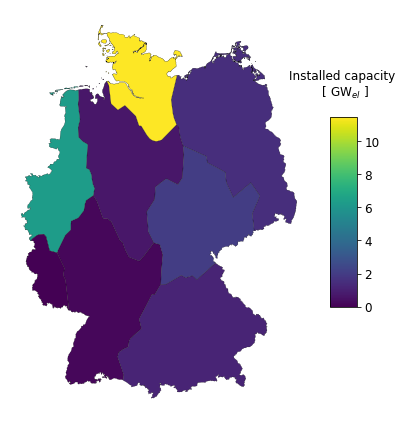

In [42]:
fig, ax = fn.plotLocationalColorMap(
    esM, "Electrolyzer", locFilePath, "index", perArea=False
)

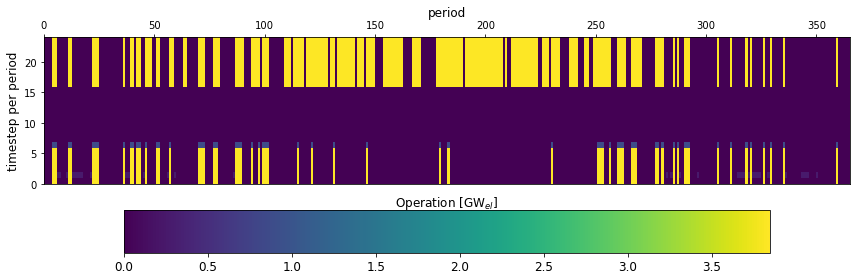

In [43]:
fig, ax = fn.plotOperationColorMap(esM, "New CCGT plants (biogas)", "cluster_2")

### Storage

Show optimization summary

In [44]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

cluster_0  \
Component               Property           Unit                                  
Li-ion batteries        TAC                [1e9 Euro/a]               0.185687   
                        capacity           [GW$_{el}$*h]               11.0509   
                        capexCap           [1e9 Euro/a]               0.163585   
                        invest             [1e9 Euro]                  1.66869   
                        operationCharge    [GW$_{el}$*h/a]             3510.49   
                                           [GW$_{el}$*h]               3510.49   
                        operationDischarge [GW$_{el}$*h/a]             3166.85   
                                           [GW$_{el}$*h]               3166.85   
                        opexCap            [1e9 Euro/a]              0.0221019   
Pumped hydro storage    TAC                [1e9 Euro/a]             0.00243637   
                        capacity           [GW$_{el}$*h]                15.924   
                        operationCharge    [GW$_{el}$*h/a]             7125.22   
                                           [GW$_{el}$*h]               7125.22   
                        operationDischarge [GW$_{el}$*h/a]              5517.6   
                                           [GW$_{el}$*h]                5517.6   
                        opexCap            [1e9 Euro/a]             0.00243637   
Salt caverns (biogas)   TAC                [1e9 Euro/a]                      0   
                        capacity           [GW$_{biogas,LHV}$*h]           NaN   
                        capexCap           [1e9 Euro/a]                    NaN   
                        invest             [1e9 Euro]                      NaN   
                        operationCharge    [GW$_{biogas,LHV}$*h/a]         NaN   
                                           [GW$_{biogas,LHV}$*h]           NaN   
                        operationDischarge [GW$_{biogas,LHV}$*h/a]         NaN   
                                           [GW$_{biogas,LHV}$*h]           NaN   
                        opexCap            [1e9 Euro/a]                    NaN   
Salt caverns (hydrogen) TAC                [1e9 Euro/a]                      0   
                        capacity           [GW$_{H_{2},LHV}$*h]            NaN   
                        capexCap           [1e9 Euro/a]                    NaN   
                        invest             [1e9 Euro]                      NaN   
                        operationCharge    [GW$_{H_{2},LHV}$*h/a]          NaN   
                                           [GW$_{H_{2},LHV}$*h]            NaN   
                        operationDischarge [GW$_{H_{2},LHV}$*h/a]          NaN   
                                           [GW$_{H_{2},LHV}$*h]            NaN   
                        opexCap            [1e9 Euro/a]                    NaN   

                                                                     cluster_1  \
Component               Property           Unit                                  
Li-ion batteries        TAC                [1e9 Euro/a]               0.405239   
                        capacity           [GW$_{el}$*h]               24.1173   
                        capexCap           [1e9 Euro/a]               0.357004   
                        invest             [1e9 Euro]                  3.64171   
                        operationCharge    [GW$_{el}$*h/a]             8949.37   
                                           [GW$_{el}$*h]               8949.37   
                        operationDischarge [GW$_{el}$*h/a]             8073.31   
                                           [GW$_{el}$*h]               8073.31   
                        opexCap            [1e9 Euro/a]              0.0482346   
Pumped hydro storage    TAC                [1e9 Euro/a]              0.0011859   
                        capacity           [GW$_{el}$*h]                 7.751   
                        operationCharge    [GW$_{e

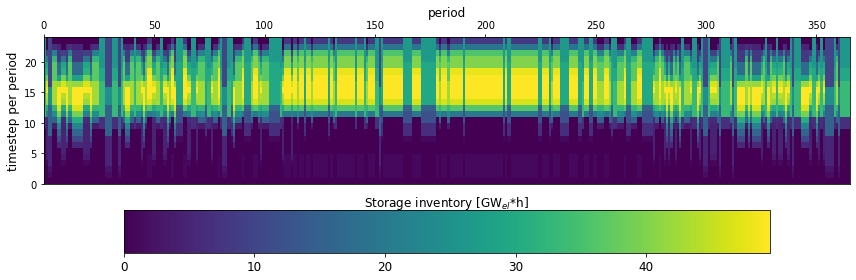

In [45]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Li-ion batteries",
    "cluster_2",
    variableName="stateOfChargeOperationVariablesOptimum",
)

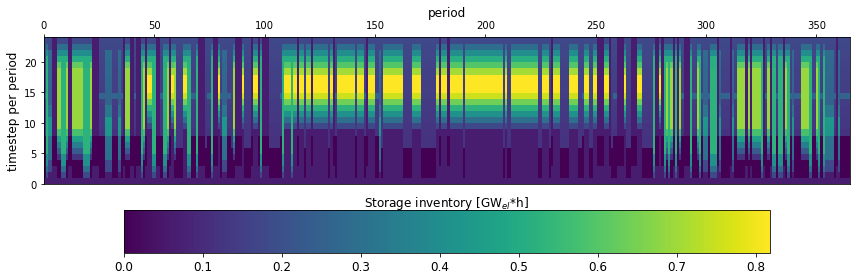

In [46]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Pumped hydro storage",
    "cluster_2",
    variableName="stateOfChargeOperationVariablesOptimum",
)

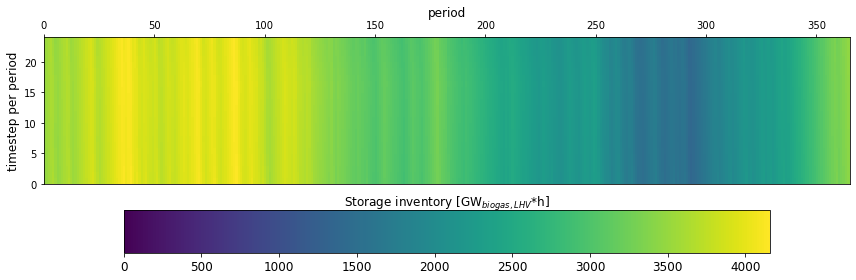

In [47]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Salt caverns (biogas)",
    "cluster_2",
    variableName="stateOfChargeOperationVariablesOptimum",
)

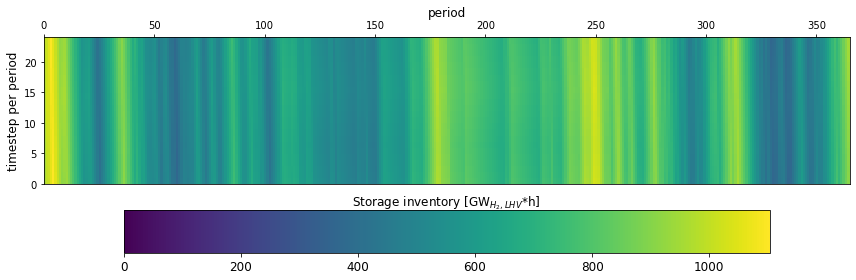

In [48]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Salt caverns (hydrogen)",
    "cluster_2",
    variableName="stateOfChargeOperationVariablesOptimum",
)

## Transmission

Show optimization summary

In [49]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2)

cluster_0  \
Component            Property  Unit                 LocationIn             
AC cables            capacity  [GW$_{el}$]          cluster_0        NaN   
                                                    cluster_1          7   
                                                    cluster_2         11   
                                                    cluster_3        NaN   
                                                    cluster_4         18   
...                                                                  ...   
Pipelines (hydrogen) operation [GW$_{H_{2},LHV}$*h] cluster_0        NaN   
                                                    cluster_1    24384.2   
                                                    cluster_2          0   
                                                    cluster_3        NaN   
                                                    cluster_6        NaN   

                                                               cluster_1  \
Component            Property  Unit                 LocationIn             
AC cables            capacity  [GW$_{el}$]          cluster_0          7   
                                                    cluster_1        NaN   
                                                    cluster_2         10   
                                                    cluster_3        NaN   
                                                    cluster_4        NaN   
...                                                                  ...   
Pipelines (hydrogen) operation [GW$_{H_{2},LHV}$*h] cluster_0    1526.81   
                                                    cluster_1        NaN   
                                                    cluster_2          0   
                                                    cluster_3          0   
                                                    cluster_6    38164.8   

                                                               cluster_2  \
Component            Property  Unit                 LocationIn             
AC cables            capacity  [GW$_{el}$]          cluster_0         11   
                                                    cluster_1         10   
                                                    cluster_2        NaN   
                                                    cluster_3        NaN   
                                                    cluster_4        NaN   
...                                                                  ...   
Pipelines (hydrogen) operation [GW$_{H_{2},LHV}$*h] cluster_0          0   
                                                    cluster_1          0   
                                                    cluster_2        NaN   
                                                    cluster_3        NaN   
                                                    cluster_6        NaN   

                                                               cluster_3  \
Component            Property  Unit                 LocationIn             
AC cables            capacity  [GW$_{el}$]          cluster_0        NaN   
                                                    cluster_1        NaN   
                                                    cluster_2        NaN   
                                                    cluster_3        NaN   
                                                    cluster_4        NaN   
...                                                                  ...   
Pipelines (hydrogen) operation [GW$_{H_{2},LHV}$*h] cluster_0        NaN   
                                                    cluster_1          0   
                                                    cluster_2        NaN   
                                                    cluster_3        NaN   
                                                    cluster_6     1193.6   

                                                               cluster_4  \
Component            Property  

In [50]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2).loc[
    "Pipelines (hydrogen)"
]

cluster_0   cluster_1  \
Property     Unit                   LocationIn                           
TAC          [1e9 Euro/a]           cluster_0            0    0.013249   
                                    cluster_1     0.013249           0   
                                    cluster_2            0           0   
                                    cluster_3            0           0   
                                    cluster_4   0.00689163           0   
                                    cluster_6            0   0.0156931   
                                    cluster_7            0           0   
capacity     [GW$_{H_{2},LHV}$]     cluster_0          NaN     2.96044   
                                    cluster_1      2.96044         NaN   
                                    cluster_2            0           0   
                                    cluster_3          NaN           0   
                                    cluster_4      1.15049         NaN   
                                    cluster_6          NaN      5.0684   
                                    cluster_7            0         NaN   
capexCap     [1e9 Euro/a]           cluster_0          NaN  0.00812938   
                                    cluster_1   0.00812938         NaN   
                                    cluster_2            0           0   
                                    cluster_3          NaN           0   
                                    cluster_4   0.00262985         NaN   
                                    cluster_6          NaN   0.0114728   
                                    cluster_7            0         NaN   
capexIfBuilt [1e9 Euro/a]           cluster_0          NaN  0.00511966   
                                    cluster_1   0.00511966         NaN   
                                    cluster_2            0          -0   
                                    cluster_3          NaN           0   
                                    cluster_4   0.00426177         NaN   
                                    cluster_6          NaN  0.00422026   
                                    cluster_7            0         NaN   
invest       [1e9 Euro]             cluster_0          NaN     0.15799   
                                    cluster_1      0.15799         NaN   
                                    cluster_2            0           0   
                                    cluster_3          NaN           0   
                                    cluster_4      0.08218         NaN   
                                    cluster_6          NaN    0.187134   
                                    cluster_7            0         NaN   
isBuilt      [-]                    cluster_0          NaN           1   
                                    cluster_1            1         NaN   
                                    cluster_2            0          -0   
                                    cluster_3          NaN           0   
                                    cluster_4            1         NaN   
                                    cluster_6          NaN           1   
                                    cluster_7            0         NaN   
operation    [GW$_{H_{2},LHV}$*h/a] cluster_0          NaN     1526.81   
                                    cluster_1      24384.2         NaN   
                                    cluster_2            0           0   
                                    cluster_3          NaN           0   
                                    cluster_6          NaN     38164.8   
             [GW$_{H_{2},LHV}$*h]   cluster_0          NaN     1526.81   
                                    cluster_1      24384.2         NaN   
                                    cluster_2            0           0   
                                    cluster_3          NaN           0   
                                    cluster_6          NaN     38164.8   

                                                  cl

Check that the shared capacity of the pipelines are not exceeded

In [51]:
df = esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc["Pipelines (biogas)"] + df.loc["Pipelines (hydrogen)"]

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
cluster_0,NaN,2.960445,1.299364,NaN,1.892217,0.0,NaN,0.000000
cluster_1,2.960445,NaN,0.000000,0.000000,NaN,0.0,5.416355,NaN
cluster_2,1.299364,0.000000,NaN,NaN,NaN,NaN,NaN,0.305141
cluster_3,NaN,0.000000,NaN,NaN,NaN,0.0,0.215147,NaN
cluster_4,1.892217,NaN,NaN,NaN,NaN,0.0,NaN,NaN
cluster_5,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
cluster_6,NaN,5.416355,NaN,0.215147,NaN,NaN,NaN,NaN
cluster_7,0.000000,NaN,0.305141,NaN,NaN,NaN,NaN,NaN


Plot installed transmission capacities

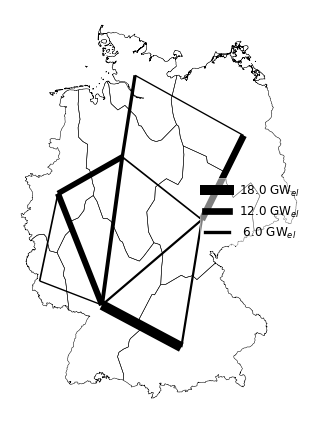

In [52]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "AClines.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "AC cables", transFilePath, loc0="bus0", loc1="bus1", fig=fig, ax=ax
)

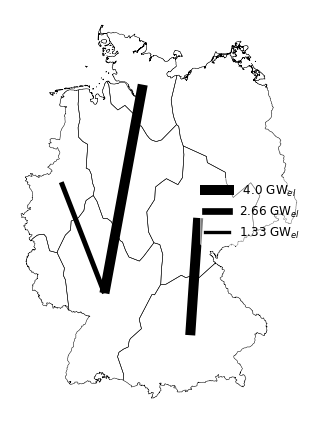

In [53]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "DClines.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "DC cables", transFilePath, loc0="cluster0", loc1="cluster1", fig=fig, ax=ax
)

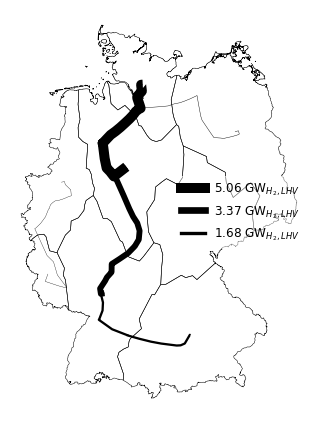

In [54]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "transmissionPipeline.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "Pipelines (hydrogen)", transFilePath, loc0="loc1", loc1="loc2", fig=fig, ax=ax
)

In [55]:
df = esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc["Pipelines (biogas)"] + df.loc["Pipelines (hydrogen)"]

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
cluster_0,NaN,2.960445,1.299364,NaN,1.892217,0.0,NaN,0.000000
cluster_1,2.960445,NaN,0.000000,0.000000,NaN,0.0,5.416355,NaN
cluster_2,1.299364,0.000000,NaN,NaN,NaN,NaN,NaN,0.305141
cluster_3,NaN,0.000000,NaN,NaN,NaN,0.0,0.215147,NaN
cluster_4,1.892217,NaN,NaN,NaN,NaN,0.0,NaN,NaN
cluster_5,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
cluster_6,NaN,5.416355,NaN,0.215147,NaN,NaN,NaN,NaN
cluster_7,0.000000,NaN,0.305141,NaN,NaN,NaN,NaN,NaN


Plot installed transmission capacities

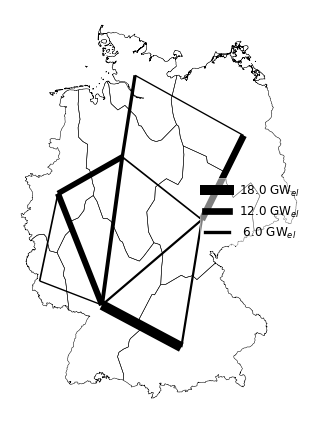

In [56]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "AClines.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "AC cables", transFilePath, loc0="bus0", loc1="bus1", fig=fig, ax=ax
)

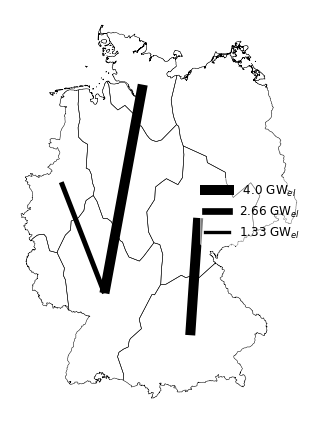

In [57]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "DClines.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "DC cables", transFilePath, loc0="cluster0", loc1="cluster1", fig=fig, ax=ax
)

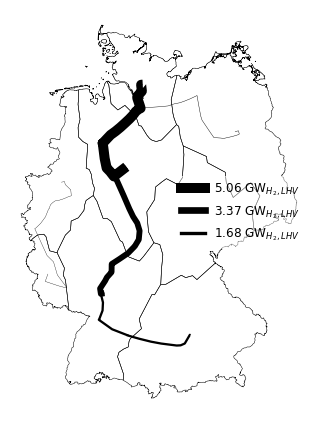

In [58]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "transmissionPipeline.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "Pipelines (hydrogen)", transFilePath, loc0="loc1", loc1="loc2", fig=fig, ax=ax
)

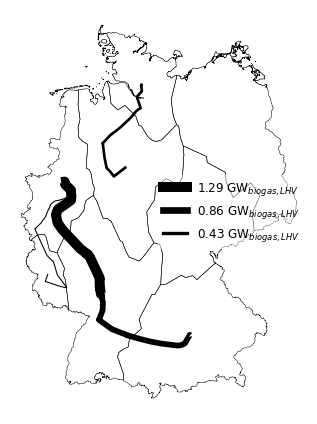

In [59]:
transFilePath = os.path.join(
    cwd, "InputData", "SpatialData", "ShapeFiles", "transmissionPipeline.shp"
)

fig, ax = fn.plotLocations(locFilePath, indexColumn="index")
fig, ax = fn.plotTransmission(
    esM, "Pipelines (biogas)", transFilePath, loc0="loc1", loc1="loc2", fig=fig, ax=ax
)